**Dataset**: The dataset from Crunchbase shows characteristics of different companies that were funded all the way from the start of the 20th Century. Each company is labelled either as "closed", "operating" or "acquired"

**Context**: As per our investigation, 90%+ of startups fail in North America, with similar rates all over the world. However, from those that do succeeed, 85% have been acquired. As a result, "acquisition" we aim to understand the variables/characteristics that increases the likelihood of a startup being acquired where Success = Acquired / Failure = Not Acquired

**Scope**: For the scope of this investigation, we will concentrate on acquisitions in the 21st Century (>1999). This will provide more value to our investigation as the business world has changed a lot since the "pre .com" era


| **Column Name**        | **Description**                                                                          |
| ---------------------- | ---------------------------------------------------------------------------------------- |
| `permalink`            | Unique identifier (URL-style) for each company or startup.                               |
| `name`                 | Name of the company or organization.                                                     |
| `homepage_url`         | Official website or homepage of the company.                                             |
| `category_list`        | Industry category or business domain the company belongs to (e.g., FinTech, HealthTech). |
| `market`               | Specific market segment within the broader category.                                     |
| `funding_total_usd`    | Total funding received by the company (in USD).                                          |
| `status`               | Operational status (e.g., operating, acquired, closed, IPO).                             |
| `country_code`         | 3-letter ISO country code of the company’s headquarters (e.g., USA, GBR, CAN).           |
| `state_code`           | Regional or state code (mainly for U.S. companies).                                      |
| `region`               | Broader geographic region of operation (e.g., North America, Europe).                    |
| `city`                 | City where the company is based.                                                         |
| `funding_rounds`       | Number of funding rounds the company has completed.                                      |
| `founded_at`           | Exact founding date of the company (YYYY-MM-DD).                                         |
| `founded_month`        | Month in which the company was founded.                                                  |
| `founded_quarter`      | Quarter in which the company was founded (e.g., Q1, Q2).                                 |
| `founded_year`         | Year the company was founded.                                                            |
| `first_funding_at`     | Date when the company received its first funding.                                        |
| `last_funding_at`      | Date when the company received its most recent funding.                                  |
| `seed`                 | Total amount raised in seed-stage funding.                                               |
| `venture`              | Total amount raised through venture capital funding.                                     |
| `equity_crowdfunding`  | Amount raised via online equity crowdfunding platforms.                                  |
| `undisclosed`          | Funding amount that was reported but not disclosed publicly.                             |
| `convertible_note`     | Amount raised through convertible notes (debt that converts to equity).                  |
| `debt_financing`       | Amount raised via loans or traditional debt instruments.                                 |
| `angel`                | Amount raised from angel investors.                                                      |
| `grant`                | Amount received through grants or non-dilutive funding sources.                          |
| `private_equity`       | Amount raised from private equity firms.                                                 |
| `post_ipo_equity`      | Amount raised from issuing additional shares after going public.                         |
| `post_ipo_debt`        | Amount raised through debt financing after going public.                                 |
| `secondary_market`     | Amount raised from secondary market transactions.                                        |
| `product_crowdfunding` | Amount raised through product-based crowdfunding platforms (e.g., Kickstarter).          |
| `round_A` to `round_H` | Amounts raised in each specific investment round (A, B, C, D, E, F, G, H).               |


## Importing Packages

In [28]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import subplots
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import RocCurveDisplay, roc_auc_score, accuracy_score, precision_score, recall_score, confusion_matrix

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor as VIF

from ISLP import load_data
from ISLP.models import (ModelSpec as MS,
                         summarize,
                         poly)

from ISLP import confusion_table


## Reading Data

In [7]:
os.chdir("/Users/lucaspenney/Documents/McGill/MGSC 661/Group Project/logistic-regression-startup-exits")
investments = pd.read_csv("investments_VC.csv", encoding="latin1",dtype={"funding_total_usd":"string"})
investments.head()

,permalink,name,homepage_url,category_list,market,funding_total_usd,status,country_code,state_code,region,...,secondary_market,product_crowdfunding,round_A,round_B,round_C,round_D,round_E,round_F,round_G,round_H
0,/organization/waywire,#waywire,http://www.waywire.com,|Entertainment|Politics|Social Media|News|,News,"17,50,000",acquired,USA,NY,New York City,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,/organization/tv-communications,&TV Communications,http://enjoyandtv.com,|Games|,Games,"40,00,000",operating,USA,CA,Los Angeles,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,/organization/rock-your-paper,'Rock' Your Paper,http://www.rockyourpaper.org,|Publishing|Education|,Publishing,"40,000",operating,EST,NaN,Tallinn,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,/organization/in-touch-network,(In)Touch Network,http://www.InTouchNetwork.com,|Electronics|Guides|Coffee|Restaurants|Music|i...,Electronics,"15,00,000",operating,GBR,NaN,London,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,/organization/r-ranch-and-mine,-R- Ranch and Mine,NaN,|Tourism|Entertainment|Games|,Tourism,"60,000",operating,USA,TX,Dallas,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
# Remove irrelevant data from DataFrame outside the scope of the investigation (only companies founded in or after 2000)

investments_2000 = investments[investments['founded_year'].ge(2000)].copy()

print("Rows remaining after filter:", investments_2000.shape[0])
print("Columns:", investments_2000.shape[1])


Rows remaining after filter: 34823
Columns: 39


In [22]:
## check size and missing values
null_data_exist=investments_2000.isnull().values.any();
null_data_count=investments_2000.isnull().values.sum();


print('Size of investments.csv data is:', investments_2000.shape)
print('Does investments.csv have missing vlaues:', null_data_exist)
investments_2000.isnull().sum().sort_values(ascending=False).head(10)

Size of investments.csv data is: (34823, 39)
Does investments.csv have missing vlaues: True


state_code       12850
city              3290
country_code      2890
region            2890
homepage_url      1822
market            1671
category_list     1666
status             777
name                 1
permalink            0
dtype: int64

### Chosing relevant columns

**Comment**: There are 39 columns. However only some of these will be relevant to the investigation. We will be removing:

- Metadata: "Permalink", "homepage_url" -> These add no value to our model.
- Irrelevant data: "founded_month","founded_quarter" -> Whether a company was founded in March or December would not explain its success. These attributes are repeated each year and we cant treat October of 1950 the same as October of 2010. These will be removed, and instead "founded_year" will be considered
- Aggregated Data: Funding_total_usd is the sum of column "round a" + ... + "round h". As a result, only Funding_total_USD will be kept, and we will drop the pieces that sum to the total
   
For now, we will keep the following relevant columns: "state_code","market", "funding_total_usd", "country_code", "city", "founded_year", "first_funding_at","last_funding_at", and "status"

Note: While the original dataset includes entries from multiple countries, this investigation will focus exclusively on the United States. Macroeconomic conditions vary significantly across regions so by doing so we are limiting distortion in our data. Also, given that the U.S. serves as a central hub for startup activity, it represents our primary area of interest.

In [10]:
# Extracting relevant columns into new dataset investments_subset 
investments_2000.columns = investments_2000.columns.str.strip()  # removing any potential extra spaces from column names

relevant_cols = [
    "state_code",
    "funding_total_usd",
    "founded_year",
    "first_funding_at",
    "last_funding_at",  
    "status",
    "market"
]

# Keep only those columns
investments_subset = investments_2000[relevant_cols].copy()
investments_subset.head()


,state_code,funding_total_usd,founded_year,first_funding_at,last_funding_at,status,market
0,NY,"17,50,000",2012.0,2012-06-30,2012-06-30,acquired,News
2,NaN,"40,000",2012.0,2012-08-09,2012-08-09,operating,Publishing
3,NaN,"15,00,000",2011.0,2011-04-01,2011-04-01,operating,Electronics
4,TX,"60,000",2014.0,2014-08-17,2014-09-26,operating,Tourism
5,FL,"70,00,000",2011.0,2013-05-31,2013-05-31,NaN,Software


In [11]:
## Checking size and missing values for investments_subset
subset_shape = investments_subset.shape
null_data_exist_subset = investments_subset.isnull().values.any()
null_data_count_subset = investments_subset.isnull().values.sum()

print('Size of investments_subset data is:', subset_shape)
print('Does investments_subset have missing values?:', null_data_exist_subset)
investments_subset.isnull().sum().sort_values(ascending=False).head(10)


Size of investments_subset data is: (34823, 7)
Does investments_subset have missing values?: True


state_code           12850
market                1671
status                 777
funding_total_usd        0
founded_year             0
first_funding_at         0
last_funding_at          0
dtype: int64

#### Chosing relevant rows

Missing values:
- State_code: Missing data in this category are because a small subset of data are non-US companies. These will be filtered
- Status and market: Missing values represent <5% of data. They will be dropped. Values missing states are outside of our scope as they are non US companies so those can also be dropped


In [25]:
problem_count = investments[
    (investments['country_code'] == 'USA') &  
    (investments['state_code'].isna())        
].shape[0]

print(f"Number of USA companies with missing state codes: {problem_count}")

# Dropping Missing Values 
investments_subset = investments_subset.dropna().copy()
print("New dataset size:", investments_subset.shape)




Number of USA companies with missing state codes: 26
New dataset size: (20780, 7)


#### Preparing Categorical Data for Analysis

Two of our explanatory variables have a lot of distinct data which would lead to a vast amount of dummy variables, making it messy and not super useful statistically. We will bin these data into identifiable groups. For instance:

- State: To reduce dimensionality in the model and improve interpretability, the 50 U.S. states are grouped based on their Business-friendly Index as per the trusted 2024 Tax Foundation State Business Tax Climate Index. This provides value in explaining which states provide the best environment for a start up to be acquired. 
- Market: We condensed the markets into a smaller set of broader industry groups to avoid creating too many dummy variables, which would slow down the model and cause memory issues. For example, instead of treating “Software,” “Enterprise Software,” and “SaaS” as separate categories, we combined them into one Software & IT group, helping us reduce 35+ industries down to 7.

In [13]:
#Grouping States
investments_subset['state_code'] = investments_subset['state_code'].str.strip()

business_groups = {
    # Tier 1 – Business Friendly
    'WY':'Business_Friendly','SD':'Business_Friendly','AK':'Business_Friendly','FL':'Business_Friendly',
    'MT':'Business_Friendly','NH':'Business_Friendly','NE':'Business_Friendly','IN':'Business_Friendly',
    'UT':'Business_Friendly','NV':'Business_Friendly','NC':'Business_Friendly','TN':'Business_Friendly',
    'ND':'Business_Friendly',

    # Tier 2 – Moderate
    'CO':'Moderate','GA':'Moderate','ID':'Moderate','OK':'Moderate','OR':'Moderate','AZ':'Moderate',
    'AL':'Moderate','WA':'Moderate','VA':'Moderate','MI':'Moderate','PA':'Moderate','KY':'Moderate',
    'SC':'Moderate','WV':'Moderate','KS':'Moderate','ME':'Moderate','WI':'Moderate','OH':'Moderate',
    'LA':'Moderate','TX':'Moderate',

    # Tier 3 – High Regulation
    'RI':'High_Regulation','HI':'High_Regulation','MD':'High_Regulation','AR':'High_Regulation',
    'MN':'High_Regulation','VT':'High_Regulation','CT':'High_Regulation','CA':'High_Regulation',
    'NY':'High_Regulation','MA':'High_Regulation','IL':'High_Regulation','NJ':'High_Regulation'
}

investments_subset['state_code'] = investments_subset['state_code'].map(business_groups).fillna('Other')

#Grouping markets

# Grouping Markets into Buckets

investments_subset['market'] = investments_subset['market'].str.strip()
bucket_mapping = {
    # Tier 1 - Media & Entertainment
    'News':'Media & Entertainment', 'Games':'Media & Entertainment', 'Publishing':'Media & Entertainment',
    'Advertising':'Media & Entertainment', 'Curated Web':'Media & Entertainment', 'Social Travel':'Media & Entertainment',
    'Sports':'Media & Entertainment', 'Chat':'Media & Entertainment', 'Video Chat':'Media & Entertainment',
    'Social Media':'Media & Entertainment', 'Photography':'Media & Entertainment', 'Art':'Media & Entertainment',
    'Blogging Platforms':'Media & Entertainment', 'Mobile Social':'Media & Entertainment', 'Messaging':'Media & Entertainment',
    'Mobile Games':'Media & Entertainment', 'Social Games':'Media & Entertainment', 'Communities':'Media & Entertainment',
    'Social Network Media':'Media & Entertainment', 'Digital Media':'Media & Entertainment', 'Social Bookmarking':'Media & Entertainment',
    'Content Syndication':'Media & Entertainment', 'Broadcasting':'Media & Entertainment', 'Opinions':'Media & Entertainment',
    'Content':'Media & Entertainment', 'Content Creators':'Media & Entertainment', 'Social + Mobile + Local':'Media & Entertainment',
    'Video Streaming':'Media & Entertainment', 'Photo Sharing':'Media & Entertainment', 'Video':'Media & Entertainment',
    'Music':'Media & Entertainment', 'Game':'Media & Entertainment', 'Entertainment':'Media & Entertainment',
    'Digital Entertainment':'Media & Entertainment', 'Virtual Worlds':'Media & Entertainment', 'Television':'Media & Entertainment',
    'Social Media Platforms':'Media & Entertainment', 'Internet Radio Market':'Media & Entertainment', 'E-Books':'Media & Entertainment',
    'Forums':'Media & Entertainment', 'Private Social Networking':'Media & Entertainment', 'Social News':'Media & Entertainment',
    'Politics':'Media & Entertainment', 'MicroBlogging':'Media & Entertainment', 'Celebrity':'Media & Entertainment',
    'Artists Globally':'Media & Entertainment', 'Religion':'Media & Entertainment', 'Theatre':'Media & Entertainment',
    'Independent Music Labels':'Media & Entertainment', 'Q&A':'Media & Entertainment', 'Concerts':'Media & Entertainment',
    'Film Distribution':'Media & Entertainment', 'TV Production':'Media & Entertainment', 'Internet TV':'Media & Entertainment',
    'Musical Instruments':'Media & Entertainment', 'Racing':'Media & Entertainment', 'Swimming':'Media & Entertainment',
    'Social Television':'Media & Entertainment', 'Comics':'Media & Entertainment', 'FreetoPlay Gaming':'Media & Entertainment',
    'Musicians':'Media & Entertainment', 'Mobile Video':'Media & Entertainment', 'Cloud-Based Music':'Media & Entertainment',
    'SNS':'Media & Entertainment', 'Performing Arts':'Media & Entertainment', 'Contests':'Media & Entertainment',
    'Music Venues':'Media & Entertainment', 'Email Newsletters':'Media & Entertainment', 'Writers':'Media & Entertainment',
    'Social Opinion Platform':'Media & Entertainment', 'Reading Apps':'Media & Entertainment', 'EBooks':'Media & Entertainment',
    'Video Games':'Media & Entertainment', 'Film Production':'Media & Entertainment', 'Music Services':'Media & Entertainment',
    'MMO Games':'Media & Entertainment', 'Fantasy Sports':'Media & Entertainment', 'Gambling':'Media & Entertainment',
    'Game Mechanics':'Media & Entertainment', 'Content Discovery':'Media & Entertainment', 'Soccer':'Media & Entertainment',
    'In-Flight Entertainment':'Media & Entertainment', 'Casual Games':'Media & Entertainment', 'Entertainment Industry':'Media & Entertainment',
    'Educational Games':'Media & Entertainment', 'PC Gaming':'Media & Entertainment', 'Film':'Media & Entertainment',
    'Journalism':'Media & Entertainment', 'Guides':'Media & Entertainment', 'Audio':'Media & Entertainment',
    'Online Gaming':'Media & Entertainment', 'Video on Demand':'Media & Entertainment', 'Video Processing':'Media & Entertainment',
    'Smart Grid':'Media & Entertainment', 'Charter Schools':'Media & Entertainment', 'Radical Breakthrough Startups':'Media & Entertainment',
    'Social Business':'Media & Entertainment', 'Social Innovation':'Media & Entertainment', 'Startups':'Media & Entertainment',
    'Smart Building':'Media & Entertainment', 'Social Commerce':'Media & Entertainment', 'Social Buying':'Media & Entertainment',
    'Online Video Advertising':'Media & Entertainment',

    # Tier 2 - Technology & Software
    'Software':'Technology & Software', 'Health Care Information Technology':'Technology & Software', 'Analytics':'Technology & Software',
    'Mobile':'Technology & Software', 'SaaS':'Technology & Software', 'Enterprise Software':'Technology & Software',
    'File Sharing':'Technology & Software', 'Mobile Security':'Technology & Software', 'Predictive Analytics':'Technology & Software',
    'Big Data':'Technology & Software', 'Hardware + Software':'Technology & Software', 'Corporate IT':'Technology & Software',
    'Web Development':'Technology & Software', '3D Printing':'Technology & Software', '3D':'Technology & Software',
    '3D Technology':'Technology & Software', 'Drones':'Technology & Software', 'Semiconductors':'Technology & Software',
    'Web Hosting':'Technology & Software', 'Android':'Technology & Software', 'Developer APIs':'Technology & Software',
    'Security':'Technology & Software', 'Flash Storage':'Technology & Software', 'Networking':'Technology & Software',
    'Machine Learning':'Technology & Software', 'Web Design':'Technology & Software', 'Cloud Computing':'Technology & Software',
    'Interface Design':'Technology & Software', 'Technology':'Technology & Software', 'Telecommunications':'Technology & Software',
    'Twitter Applications':'Technology & Software', 'Business Productivity':'Technology & Software', 'Communications Hardware':'Technology & Software',
    'EDA Tools':'Technology & Software', 'Virtualization':'Technology & Software', 'Cloud Infrastructure':'Technology & Software',
    'M2M':'Technology & Software', 'Identity Management':'Technology & Software', 'Information Security':'Technology & Software',
    'Apps':'Technology & Software', 'Information Technology':'Technology & Software', 'Medical Devices':'Technology & Software',
    'Cloud Management':'Technology & Software', 'Vertical Search':'Technology & Software', 'Internet of Things':'Technology & Software',
    'Semantic Search':'Technology & Software', 'Internet':'Technology & Software', 'Business Intelligence':'Technology & Software',
    'Email':'Technology & Software', 'Development Platforms':'Technology & Software', 'Semantic Web':'Technology & Software',
    'Collaboration':'Technology & Software', 'Assisitive Technology':'Technology & Software', 'Facebook Applications':'Technology & Software',
    'Location Based Services':'Technology & Software', 'Trusted Networks':'Technology & Software', 'Data Visualization':'Technology & Software',
    'Enterprise Search':'Technology & Software', 'Optimization':'Technology & Software', 'Application Platforms':'Technology & Software',
    'Computers':'Technology & Software', 'Real Time':'Technology & Software', 'Digital Signage':'Technology & Software',
    'RIM':'Technology & Software', 'Databases':'Technology & Software', 'Displays':'Technology & Software',
    'Meeting Software':'Technology & Software', 'Retail Technology':'Technology & Software', 'Tablets':'Technology & Software',
    'Gps':'Technology & Software', 'Web CMS':'Technology & Software', 'Sensors':'Technology & Software',
    'iPhone':'Technology & Software', 'Human Computer Interaction':'Technology & Software', 'Local Search':'Technology & Software',
    'Computer Vision':'Technology & Software', 'Cloud Security':'Technology & Software', 'Credit':'Technology & Software',
    'Document Management':'Technology & Software', 'Data Mining':'Technology & Software', 'Linux':'Technology & Software',
    'App Stores':'Technology & Software', 'Open Source':'Technology & Software', 'iPad':'Technology & Software',
    'Big Data Analytics':'Technology & Software', 'Data Integration':'Technology & Software', 'College Recruiting':'Technology & Software',
    'Knowledge Management':'Technology & Software', 'Social Media Monitoring':'Technology & Software', 'Portals':'Technology & Software',
    'Graphics':'Technology & Software', 'Mobile Software Tools':'Technology & Software', 'Enterprise Security':'Technology & Software',
    'Mobile Enterprise':'Technology & Software', 'Homeland Security':'Technology & Software', 'Mobile Devices':'Technology & Software',
    'Developer Tools':'Technology & Software', 'PaaS':'Technology & Software', 'Application Performance Monitoring':'Technology & Software',
    'Testing':'Technology & Software', 'User Experience Design':'Technology & Software', 'QR Codes':'Technology & Software',
    'Cyber Security':'Technology & Software', 'CRM':'Technology & Software', 'Enterprise Application':'Technology & Software',
    'Browser Extensions':'Technology & Software', 'Contact Management':'Technology & Software', 'Data Security':'Technology & Software',
    'Deep Information Technology':'Technology & Software', 'Augmented Reality':'Technology & Software', 'Universities':'Technology & Software',
    'Web Tools':'Technology & Software', 'Visualization':'Technology & Software', 'Physical Security':'Technology & Software',
    'Identity':'Technology & Software', 'Tracking':'Technology & Software', 'RFID':'Technology & Software',
    'E-Commerce Platforms':'Technology & Software', 'Productivity Software':'Technology & Software', 'NFC':'Technology & Software',
    'Content Delivery':'Technology & Software', 'Video Conferencing':'Technology & Software', 'Network Security':'Technology & Software',
    'VoIP':'Technology & Software', 'Storage':'Technology & Software', 'Social Search':'Technology & Software',
    'Peer-to-Peer':'Technology & Software', 'Project Management':'Technology & Software', 'Data Privacy':'Technology & Software',
    'Algorithms':'Technology & Software', 'IT and Cybersecurity':'Technology & Software', 'Biometrics':'Technology & Software',
    'High Tech':'Technology & Software', 'Enterprise Hardware':'Technology & Software', 'Infrastructure':'Technology & Software',
    'Data Centers':'Technology & Software', 'Image Recognition':'Technology & Software', 'IaaS':'Technology & Software',
    'Credit Cards':'Technology & Software', 'CAD':'Technology & Software', 'Ediscovery':'Technology & Software',
    'University Students':'Technology & Software', 'Customer Support Tools':'Technology & Software', 'Proximity Internet':'Technology & Software',
    'Tech Field Support':'Technology & Software', 'Text Analytics':'Technology & Software', 'Embedded Hardware and Software':'Technology & Software',
    'Bridging Online and Offline':'Technology & Software', 'Synchronization':'Technology & Software', 'Utilities':'Technology & Software',
    'Digital Rights Management':'Technology & Software', 'Communications Infrastructure':'Technology & Software', 'Systems':'Technology & Software',
    'Senior Citizens':'Technology & Software', 'Architecture':'Technology & Software', 'Google Apps':'Technology & Software',
    'Social Recruiting':'Technology & Software', 'WebOS':'Technology & Software', 'Natural Language Processing':'Technology & Software',
    'Windows Phone 7':'Technology & Software', 'New Product Development':'Technology & Software', 'Supply Chain Management':'Technology & Software',
    'Indoor Positioning':'Technology & Software', 'Usability':'Technology & Software', 'Domains':'Technology & Software',
    'Software Compliance':'Technology & Software', 'Registrars':'Technology & Software', 'App Discovery':'Technology & Software',
    'Motion Capture':'Technology & Software', 'Intelligent Systems':'Technology & Software', 'China Internet':'Technology & Software',
    'New Technologies':'Technology & Software', 'Point of Sale':'Technology & Software', 'Data Center Infrastructure':'Technology & Software',
    'Unmanned Air Systems':'Technology & Software', 'Business Information Systems':'Technology & Software', 'Commodities':'Technology & Software',
    'Speech Recognition':'Technology & Software', 'Face Recognition':'Technology & Software', 'ICT':'Technology & Software',
    'Self Development':'Technology & Software', 'Kinect':'Technology & Software', 'Web Browsers':'Technology & Software',
    'Presentations':'Technology & Software', 'Internet Service Providers':'Technology & Software', 'Rapidly Expanding':'Technology & Software',
    'Video Editing':'Technology & Software', 'Biotechnology and Semiconductor':'Technology & Software', 'Visual Search':'Technology & Software',
    'Internet Infrastructure':'Technology & Software', 'Cyber':'Technology & Software', 'Group SMS':'Technology & Software',
    'Lasers':'Technology & Software', 'Weird Hardware':'Technology & Software', 'Energy IT':'Technology & Software',
    'Mac':'Technology & Software', 'Renewable Tech':'Technology & Software', 'Enterprise 2.0':'Technology & Software',
    'Photo Editing':'Technology & Software', 'Google Glass':'Technology & Software', 'Mobile Infrastructure':'Technology & Software',
    'Data Center Automation':'Technology & Software', 'Personal Data':'Technology & Software', 'Internet Technology':'Technology & Software',
    'Fraud Detection':'Technology & Software', 'Quantitative Marketing':'Technology & Software', 'Online Identity':'Technology & Software',
    'Gadget':'Technology & Software', 'Early-Stage Technology':'Technology & Software', 'Simulation':'Technology & Software',
    'Test and Measurement':'Technology & Software', 'Automated Kiosk':'Technology & Software', 'Clean Technology IT':'Technology & Software',
    'Finance Technology':'Technology & Software', 'Mobile Analytics':'Technology & Software', 'Cloud Data Services':'Technology & Software',
    'Privacy':'Technology & Software', 'SMS':'Technology & Software', 'Artificial Intelligence':'Technology & Software',
    'Bitcoin':'Technology & Software', 'Navigation':'Technology & Software', 'Maps':'Technology & Software',
    'Nanotechnology':'Technology & Software', 'Mining Technologies':'Technology & Software', 'Nonprofits':'Technology & Software',
    'Recruiting':'Technology & Software', 'Advertising Platforms':'Technology & Software', 'Email Marketing':'Technology & Software',
    'Social CRM':'Technology & Software', 'Hardware':'Technology & Software', 'IT Management':'Technology & Software',
    'Charity':'Technology & Software', 'Employer Benefits Programs':'Technology & Software', 'Nutrition':'Technology & Software',
    'Sustainability':'Technology & Software', 'Non Profit':'Technology & Software', 'Venture Capital':'Technology & Software',
    'Search':'Technology & Software', 'Gamification':'Technology & Software', 'Fitness':'Technology & Software',
    'Retail':'Technology & Software', 'DOD/Military':'Technology & Software', 'Product Development Services':'Technology & Software',
    'Specialty Retail':'Technology & Software', 'Hospitals':'Technology & Software', 'Wireless':'Technology & Software',

    # Tier 3 - Business Services
    'Designers':'Business Services', 'Sales and Marketing':'Business Services', 'Services':'Business Services',
    'Outsourcing':'Business Services', 'Customer Service':'Business Services', 'Human Resources':'Business Services',
    'Entrepreneur':'Business Services', 'Business Services':'Business Services', 'Career Management':'Business Services',
    'Small and Medium Businesses':'Business Services', 'SEO':'Business Services', 'Task Management':'Business Services',
    'Public Relations':'Business Services', 'Consulting':'Business Services', 'Design':'Business Services',
    'Creative':'Business Services', 'Events':'Business Services', 'Brand Marketing':'Business Services',
    'Ad Targeting':'Business Services', 'Social Media Advertising':'Business Services', 'Lead Generation':'Business Services',
    'Online Scheduling':'Business Services', 'Outdoor Advertising':'Business Services', 'App Marketing':'Business Services',
    'Legal':'Business Services', 'Advice':'Business Services', 'Advertising Exchanges':'Business Services',
    'Business Development':'Business Services', 'Personal Branding':'Business Services', 'Crowdsourcing':'Business Services',
    'Information Services':'Business Services', 'Product Design':'Business Services', 'Enterprises':'Business Services',
    'BPO Services':'Business Services', 'Reputation':'Business Services', 'Training':'Business Services',
    'Loyalty Programs':'Business Services', 'Social Media Marketing':'Business Services', 'Freelancers':'Business Services',
    'Market Research':'Business Services', 'Service Providers':'Business Services', 'Professional Services':'Business Services',
    'Local Advertising':'Business Services', 'Creative Industries':'Business Services', 'Direct Marketing':'Business Services',
    'Consumer Behavior':'Business Services', 'Incubators':'Business Services', 'Coworking':'Business Services',
    'Career Planning':'Business Services', 'World Domination':'Business Services', 'Moneymaking':'Business Services',
    'Intellectual Property':'Business Services', 'Printing':'Business Services', 'Staffing Firms':'Business Services',
    'All Markets':'Business Services', 'Employment':'Business Services', 'Shared Services':'Business Services',
    'Governments':'Business Services', 'Engineering Firms':'Business Services', 'Professional Networking':'Business Services',
    'Ventures for Good':'Business Services', 'Procurement':'Business Services', 'Law Enforcement':'Business Services',
    'Funeral Industry':'Business Services', 'Freemium':'Business Services', 'Interior Design':'Business Services',
    'Skill Assessment':'Business Services', 'Innovation Management':'Business Services', 'Public Safety':'Business Services',
    'Polling':'Business Services', 'Humanitarian':'Business Services', 'Surveys':'Business Services',
    'Contact Centers':'Business Services', 'Human Resource Automation':'Business Services', 'Call Center Automation':'Business Services',
    'Innovation Engineering':'Business Services', 'Lifestyle Businesses':'Business Services', 'Offline Businesses':'Business Services',
    'Governance':'Business Services', 'Demographies':'Business Services', 'Homeless Shelter':'Business Services',
    'Government Innovation':'Business Services', 'Niche Specific':'Business Services', 'Web Presence Management':'Business Services',
    'Franchises':'Business Services', 'Social Media Agent':'Business Services', 'Enterprise Purchasing':'Business Services',
    'Estimation and Quoting':'Business Services', 'Multi-level Marketing':'Business Services', 'Service Industries':'Business Services',
    'Internet Marketing':'Business Services', 'Promotional':'Business Services', 'Search Marketing':'Business Services',
    'Mobile Advertising':'Business Services', 'Lead Management':'Business Services', 'Performance Marketing':'Business Services',
    'Advertising Networks':'Business Services', 'Civil Engineers':'Business Services', 'Translation':'Business Services',
    'Corporate Training':'Business Services', 'Sales Automation':'Business Services', 'Sponsorship':'Business Services',
    'Intellectual Asset Management':'Business Services', 'Event Management':'Business Services',

    # Tier 4 - Consumer & Retail
    'Electronics':'Consumer & Retail', 'E-Commerce':'Consumer & Retail', 'Marketplaces':'Consumer & Retail',
    'Restaurants':'Consumer & Retail', 'Fashion':'Consumer & Retail', 'Mobile Commerce':'Consumer & Retail',
    'Lifestyle':'Consumer & Retail', 'Wine And Spirits':'Consumer & Retail', 'Consumer Electronics':'Consumer & Retail',
    'Kids':'Consumer & Retail', 'Pets':'Consumer & Retail', 'Women':'Consumer & Retail',
    'Specialty Foods':'Consumer & Retail', 'Online Shopping':'Consumer & Retail', 'Coupons':'Consumer & Retail',
    'Collectibles':'Consumer & Retail', 'Classifieds':'Consumer & Retail', 'Auctions':'Consumer & Retail',
    'Comparison Shopping':'Consumer & Retail', 'Consumers':'Consumer & Retail', 'Shopping':'Consumer & Retail',
    'Match-Making':'Consumer & Retail', 'Online Rental':'Consumer & Retail', 'Groceries':'Consumer & Retail',
    'Weddings':'Consumer & Retail', 'Lighting':'Consumer & Retail', 'Craft Beer':'Consumer & Retail',
    'Craigslist Killers':'Consumer & Retail', 'Consumer Goods':'Consumer & Retail', 'Reviews and Recommendations':'Consumer & Retail',
    'Toys':'Consumer & Retail', 'Handmade':'Consumer & Retail', 'Online Dating':'Consumer & Retail',
    'Consumer Internet':'Consumer & Retail', 'Subscription Businesses':'Consumer & Retail', 'Ticketing':'Consumer & Retail',
    'Babies':'Consumer & Retail', 'Price Comparison':'Consumer & Retail', 'Group Buying':'Consumer & Retail',
    'Jewelry':'Consumer & Retail', 'Home Decor':'Consumer & Retail', 'Wholesale':'Consumer & Retail',
    'Farmers Market':'Consumer & Retail', 'Baby Accessories':'Consumer & Retail', 'Parenting':'Consumer & Retail',
    'Lifestyle Products':'Consumer & Retail', 'Discounts':'Consumer & Retail', 'Organic':'Consumer & Retail',
    'Collaborative Consumption':'Consumer & Retail', 'Organic Food':'Consumer & Retail', 'Low Bid Auctions':'Consumer & Retail',
    'Shoes':'Consumer & Retail', 'Teenagers':'Consumer & Retail', 'Cosmetics':'Consumer & Retail',
    'General Public Worldwide':'Consumer & Retail', 'Flowers':'Consumer & Retail', 'Flash Sales':'Consumer & Retail',
    'Cooking':'Consumer & Retail', 'Coffee':'Consumer & Retail', 'Leisure':'Consumer & Retail',
    'Gift Card':'Consumer & Retail', 'Nightlife':'Consumer & Retail', 'Home Renovation':'Consumer & Retail',
    'Nightclubs':'Consumer & Retail', 'Recipes':'Consumer & Retail', 'Mobile Coupons':'Consumer & Retail',
    'Sex':'Consumer & Retail', 'Product Search':'Consumer & Retail', 'Sporting Goods':'Consumer & Retail',
    'Local Coupons':'Consumer & Retail', 'Debt Collecting':'Consumer & Retail', 'Doctors':'Consumer & Retail',
    'Wealth Management':'Consumer & Retail', 'Transaction Processing':'Consumer & Retail', 'Eyewear':'Consumer & Retail',
    'Green Consumer Goods':'Consumer & Retail', 'Retirement':'Consumer & Retail', 'Online Auctions':'Consumer & Retail',
    'Recreation':'Consumer & Retail', 'Bicycles':'Consumer & Retail', 'Vacation Rentals':'Consumer & Retail',
    'Virtual Goods':'Consumer & Retail', 'Families':'Consumer & Retail', 'Twin-Tip Skis':'Consumer & Retail',
    'Lotteries':'Consumer & Retail', 'DIY':'Consumer & Retail', 'Gift Exchange':'Consumer & Retail',
    'Home Owners':'Consumer & Retail', 'Sunglasses':'Consumer & Retail', 'Lingerie':'Consumer & Retail',
    'Tea':'Consumer & Retail', 'Young Adults':'Consumer & Retail', 'Vending and Concessions':'Consumer & Retail',
    'Baby Boomers':'Consumer & Retail', 'Timeshares':'Consumer & Retail', 'Beauty':'Consumer & Retail',
    'Home Automation':'Consumer & Retail', 'Home & Garden':'Consumer & Retail', 'Consumer Lending':'Consumer & Retail',
    'Food Processing':'Consumer & Retail', 'Direct Sales':'Consumer & Retail', 'Mobile Shopping':'Consumer & Retail',
    'Golf Equipment':'Consumer & Retail',

    # Tier 5 - Health & Wellness
    'Health and Wellness':'Health & Wellness', 'Personal Health':'Health & Wellness', 'Mobile Health':'Health & Wellness',
    'Health Care':'Health & Wellness', 'Medical':'Health & Wellness', 'Biotechnology':'Health & Wellness',
    'Pharmaceuticals':'Health & Wellness', 'Life Sciences':'Health & Wellness', 'Physicians':'Health & Wellness',
    'Electronic Health Records':'Health & Wellness', 'Exercise':'Health & Wellness', 'Healthcare Services':'Health & Wellness',
    'Bio-Pharm':'Health & Wellness', 'Health Services Industry':'Health & Wellness', 'Psychology':'Health & Wellness',
    'Alternative Medicine':'Health & Wellness', 'Genetic Testing':'Health & Wellness', 'Dental':'Health & Wellness',
    'Diabetes':'Health & Wellness', 'Diagnostics':'Health & Wellness', 'Neuroscience':'Health & Wellness',
    'Medical Professionals':'Health & Wellness', 'mHealth':'Health & Wellness', 'Synthetic Biology':'Health & Wellness',
    'Spas':'Health & Wellness', 'Medical Marijuana Patients':'Health & Wellness', 'Elder Care':'Health & Wellness',
    'Remediation':'Health & Wellness', 'Clinical Trials':'Health & Wellness', 'Veterinary':'Health & Wellness',
    'Cosmetic Surgery':'Health & Wellness', 'Rehabilitation':'Health & Wellness', 'Senior Health':'Health & Wellness',
    'Dietary Supplements':'Health & Wellness', 'Therapeutics':'Health & Wellness', 'Bioinformatics':'Health & Wellness',
    'Corporate Wellness':'Health & Wellness', 'Mobile Emergency&Health':'Health & Wellness', 'Quantified Self':'Health & Wellness',
    'Social Media Management':'Health & Wellness',

    # Tier 6 - Finance & Insurance
    'Finance':'Finance & Insurance', 'Financial Services':'Finance & Insurance', 'Social Fundraising':'Finance & Insurance',
    'Payments':'Finance & Insurance', 'Mobile Payments':'Finance & Insurance', 'Accounting':'Finance & Insurance',
    'P2P Money Transfer':'Finance & Insurance', 'Personal Finance':'Finance & Insurance', 'Insurance':'Finance & Insurance',
    'Banking':'Finance & Insurance', 'Stock Exchanges':'Finance & Insurance', 'Financial Exchanges':'Finance & Insurance',
    'Trading':'Finance & Insurance', 'Virtual Currency':'Finance & Insurance', 'Investment Management':'Finance & Insurance',
    'Crowdfunding':'Finance & Insurance', 'Real Estate Investors':'Finance & Insurance', 'Angels':'Finance & Insurance',
    'Risk Management':'Finance & Insurance', 'Billing':'Finance & Insurance', 'Emerging Markets':'Finance & Insurance',
    'Health and Insurance':'Finance & Insurance', 'Gold':'Finance & Insurance', 'Insurance Companies':'Finance & Insurance',
    'Resorts':'Finance & Insurance', 'Hedge Funds':'Finance & Insurance', 'Social Investing':'Finance & Insurance',
    'Brokers':'Finance & Insurance',

    # Tier 7 - Real Estate & Local Services
    'Real Estate':'Real Estate & Local Services', 'Local Businesses':'Real Estate & Local Services', 'Commercial Real Estate':'Real Estate & Local Services',
    'Local Based Services':'Real Estate & Local Services', 'Construction':'Real Estate & Local Services', 'Office Space':'Real Estate & Local Services',
    'Local':'Real Estate & Local Services', 'Rental Housing':'Real Estate & Local Services', 'Property Management':'Real Estate & Local Services',
    'Local Commerce':'Real Estate & Local Services', 'Plumbers':'Real Estate & Local Services', 'Infrastructure Builders':'Real Estate & Local Services',
    'Realtors':'Real Estate & Local Services', 'Self Storage':'Real Estate & Local Services', 'Green Building':'Real Estate & Local Services',

    # Tier 8 - Industrial & Energy
    'Tourism':'Industrial & Energy', 'Mobility':'Industrial & Energy', 'Manufacturing':'Industrial & Energy',
    'Travel':'Industrial & Energy', 'Hospitality':'Industrial & Energy', 'Transportation':'Industrial & Energy',
    'Clean Technology':'Industrial & Energy', 'Carbon':'Industrial & Energy', 'Distribution':'Industrial & Energy',
    'Online Travel':'Industrial & Energy', 'Automotive':'Industrial & Energy', 'Batteries':'Industrial & Energy',
    'Solar':'Industrial & Energy', 'Water Purification':'Industrial & Energy', 'Travel & Tourism':'Industrial & Energy',
    'Adventure Travel':'Industrial & Energy', 'Defense':'Industrial & Energy', 'Aerospace':'Industrial & Energy',
    'Energy':'Industrial & Energy', 'Agriculture':'Industrial & Energy', 'Recycling':'Industrial & Energy',
    'Public Transportation':'Industrial & Energy', 'Biomass Power Generation':'Industrial & Energy', 'Distributors':'Industrial & Energy',
    'Animal Feed':'Industrial & Energy', 'Renewable Energies':'Industrial & Energy', 'Material Science':'Industrial & Energy',
    'Logistics':'Industrial & Energy', 'Chemicals':'Industrial & Energy', 'Robotics':'Industrial & Energy',
    'Oil':'Industrial & Energy', 'Oil & Gas':'Industrial & Energy', 'Oil and Gas':'Industrial & Energy',
    'Logistics Company':'Industrial & Energy', 'Industrial Automation':'Industrial & Energy', 'Natural Resources':'Industrial & Energy',
    'Minerals':'Industrial & Energy', 'Water':'Industrial & Energy', 'Boating Industry':'Industrial & Energy',
    'Textiles':'Industrial & Energy', 'Hotels':'Industrial & Energy', 'Taxis':'Industrial & Energy',
    'Auto':'Industrial & Energy', 'Parking':'Industrial & Energy', 'Environmental Innovation':'Industrial & Energy',
    'Advanced Materials':'Industrial & Energy', 'Motors':'Industrial & Energy', 'Farming':'Industrial & Energy',
    'Electrical Distribution':'Industrial & Energy', 'Energy Efficiency':'Industrial & Energy', 'Electric Vehicles':'Industrial & Energy',
    'Fleet Management':'Industrial & Energy', 'Green':'Industrial & Energy', 'Residential Solar':'Industrial & Energy',
    'Shipping':'Industrial & Energy', 'Heavy Industry':'Industrial & Energy', 'B2B Express Delivery':'Industrial & Energy',
    'Commercial Solar':'Industrial & Energy', 'Mechanical Solutions':'Industrial & Energy', 'Natural Gas Uses':'Industrial & Energy',
    'Industrial Energy Efficiency':'Industrial & Energy', 'Biofuels':'Industrial & Energy', 'Fuels':'Industrial & Energy',
    'Wind':'Industrial & Energy', 'Rural Energy':'Industrial & Energy', 'Energy Management':'Industrial & Energy',
    'Distributed Generation':'Industrial & Energy', 'Marketing Automation':'Industrial & Energy', 'Clean Energy':'Industrial & Energy',
    'Semiconductor Manufacturing Equipment':'Industrial & Energy', 'Energy Storage':'Industrial & Energy', 'Cars':'Industrial & Energy',
    'Postal and Courier Services':'Industrial & Energy', 'Gas':'Industrial & Energy', 'Space Travel':'Industrial & Energy',

    # Tier 9 - Education
    'Education':'Education', 'Technical Continuing Education':'Education', 'Colleges':'Education',
    'Alumni':'Education', 'Language Learning':'Education', 'K-12 Education':'Education',
    'B2B':'Education', 'Tutoring':'Education', 'Teachers':'Education',
    'Textbooks':'Education', 'All Students':'Education', 'College Campuses':'Education',
    'High Schools':'Education', 'Music Education':'Education', 'Certification Test':'Education',
    'English-Speaking':'Education',
}

investments_subset['market'] = investments_subset['market'].map(bucket_mapping).fillna('Other')


In [14]:
# Checking the new tiers
investments_subset.head()

,state_code,funding_total_usd,founded_year,first_funding_at,last_funding_at,status,market
0,High_Regulation,"17,50,000",2012.0,2012-06-30,2012-06-30,acquired,Media & Entertainment
4,Moderate,"60,000",2014.0,2014-08-17,2014-09-26,operating,Industrial & Energy
8,High_Regulation,-,2010.0,2014-07-24,2014-07-24,operating,Technology & Software
14,Business_Friendly,-,2013.0,2014-01-22,2014-01-22,operating,Real Estate & Local Services
16,High_Regulation,"20,50,000",2001.0,2009-06-18,2011-12-28,operating,Consumer & Retail


### Preparing the data for logistic regression

1. We will need to make the Dependant variable binary. Our goal (Dependent Variable) is to predict likelihood of acquisition: 𝑌𝑖 =1 if startup is acquired, 0 othwerwise. 
2. We will also have to manipulate the explanatory variables:

- Firstly, we need to ensure we strip the data given some possible "messy" entries in the dataset
- Funding total usd is "Object" data type. Some entries are '-', and we need to convert to float for the model.
- Lastly, Year datatypes such as "first_funding_at" and "last_funding_at" need to be converted to floats too


In [ ]:
investments_clean = investments_subset.copy()

# Stripping data
for c in ['state_code', 'bucket', 'status', 'funding_total_usd',
          'first_funding_at', 'last_funding_at']:
    if c in investments_clean.columns:
        investments_clean[c] = investments_clean[c].astype(str).str.strip()

# Convert date columns to year

for c in ['first_funding_at', 'last_funding_at']:
    if c in investments_clean.columns:
        investments_clean[c] = pd.to_datetime(investments_clean[c], errors='coerce')

investments_clean['first_funding_year'] = investments_clean['first_funding_at'].dt.year
investments_clean['last_funding_year']  = investments_clean['last_funding_at'].dt.year

investments_clean.drop(columns=[c for c in ['first_funding_at','last_funding_at'] if c in investments_clean.columns],
                       inplace=True)

#  Clean funding_total_usd to numeric

if 'funding_total_usd' in investments_clean.columns:
    
    # Remove whitespace & convert to string
    s = investments_clean['funding_total_usd'].astype(str).str.strip()

    # Identify invalid entries ("-" or blank)
    invalid = (s == "-") | (s == "") | (s == " ")

    # Drop rows with invalid funding values
    investments_clean = investments_clean[~invalid].copy()

    # Remove symbols like commas and $ and convert to numeric
    s = s.str.replace(r'[^\d\.]', '', regex=True)
    s = s.replace({'': np.nan, '.': np.nan})

    investments_clean['funding_total_usd'] = pd.to_numeric(s, errors='coerce')

#  Ensure numeric columns

for c in ['founded_year', 'first_funding_year', 'last_funding_year', 'funding_total_usd']:
    if c in investments_clean.columns:
        investments_clean[c] = pd.to_numeric(investments_clean[c], errors='coerce').astype('float64')

In [16]:
display(investments_clean[['state_code','market']].head())

,state_code,market
0,High_Regulation,Media & Entertainment
4,Moderate,Industrial & Energy
16,High_Regulation,Consumer & Retail
17,Moderate,Technology & Software
20,High_Regulation,Media & Entertainment


In [17]:
# Create binary target variable
investments_clean['acquired'] = (investments_clean['status'].str.lower() == 'acquired').astype(int)

#Drop rows missing required fields
essential = ['acquired', 'state_code', 'bucket',
             'funding_total_usd', 'founded_year',
             'first_funding_year', 'last_funding_year']

present = [c for c in essential if c in investments_clean.columns]

before = len(investments_clean)
investments_clean = investments_clean.dropna(subset=present).copy()
after = len(investments_clean)

print(f"Rows kept: {after} / {before}  (Dropped {before-after})")

# ============================================
# STEP 8 — Final audit
# ============================================
print("\nDtypes:")
print(investments_clean.dtypes)

print("\nTarget distribution (acquired):")
print(investments_clean['acquired'].value_counts(dropna=False))

print("\nSample rows:")
display(investments_clean.head())


Rows kept: 17815 / 17815  (Dropped 0)

Dtypes:
state_code             object
funding_total_usd     float64
founded_year          float64
status                 object
market                 object
first_funding_year    float64
last_funding_year     float64
acquired                int64
dtype: object

Target distribution (acquired):
acquired
0    16079
1     1736
Name: count, dtype: int64

Sample rows:


,state_code,funding_total_usd,founded_year,status,market,first_funding_year,last_funding_year,acquired
0,High_Regulation,1750000.0,2012.0,acquired,Media & Entertainment,2012.0,2012.0,1
4,Moderate,60000.0,2014.0,operating,Industrial & Energy,2014.0,2014.0,0
16,High_Regulation,2050000.0,2001.0,operating,Consumer & Retail,2009.0,2011.0,0
17,Moderate,40000.0,2008.0,operating,Technology & Software,2011.0,2011.0,0
20,High_Regulation,2535000.0,2010.0,acquired,Media & Entertainment,2010.0,2011.0,1


In [18]:
#From ChatGPT - A checklist to make sure code is OK to run in the regression with data as expected by the Syntax

print("=== DATASET PRE-CHECK (investments_clean) ===")

# 0) Basic size
print(f"Rows: {len(investments_clean)}, Cols: {investments_clean.shape[1]}")

# 1) Target sanity
print("\nTarget distribution (acquired):")
print(investments_clean['acquired'].value_counts(dropna=False))
print("Target dtype:", investments_clean['acquired'].dtype)

# 2) Required columns
required_cols = ['acquired','state_code','market',
                 'funding_total_usd','founded_year','first_funding_year','last_funding_year']
missing_cols = [c for c in required_cols if c not in investments_clean.columns]
print("\nMissing required columns:", missing_cols if missing_cols else "None ✅")

# 3) Numeric columns check (use only those that exist)
numeric_cols = [c for c in ['funding_total_usd','founded_year','first_funding_year','last_funding_year']
                if c in investments_clean.columns]

print("\nNumeric dtype check:")
print(investments_clean[numeric_cols].dtypes)

if investments_clean[numeric_cols].isnull().any().any():
    print("⚠️ NaNs found in numeric vars")
else:
    print("✅ No NaNs in numeric vars")

# Non-finite check
all_finite = np.isfinite(investments_clean[numeric_cols].to_numpy()).all()
print("Non-finite values present in numeric vars?:", "❌ Yes" if not all_finite else "✅ No")

# 4) Categorical dtype check
cat_cols = [c for c in ['state_code','market'] if c in investments_clean.columns]
print("\nCategorical dtype check:")
print(investments_clean[cat_cols].dtypes)

# 5) Object columns (unexpected)
obj_cols = investments_clean.select_dtypes(include='object').columns.tolist()
print("\nColumns with object dtype (besides expected categoricals):",
      [c for c in obj_cols if c not in cat_cols] or "✅ None")

# 6) Zero-variance columns (compute on numeric cols only; no boolean indexing on the full DF)
num_only = investments_clean.select_dtypes(include=[np.number])
std_series = num_only.std()   # indexed by numeric columns only
zero_var_cols = std_series[std_series == 0].index.tolist()
print("\nZero-variance numeric columns:", zero_var_cols if zero_var_cols else "✅ None")

# 7) Quick preview
print("\nSample rows:")
display(investments_clean.head())


=== DATASET PRE-CHECK (investments_clean) ===
Rows: 17815, Cols: 8

Target distribution (acquired):
acquired
0    16079
1     1736
Name: count, dtype: int64
Target dtype: int64

Missing required columns: None ✅

Numeric dtype check:
funding_total_usd     float64
founded_year          float64
first_funding_year    float64
last_funding_year     float64
dtype: object
✅ No NaNs in numeric vars
Non-finite values present in numeric vars?: ✅ No

Categorical dtype check:
state_code    object
market        object
dtype: object

Columns with object dtype (besides expected categoricals): ['status']

Zero-variance numeric columns: ✅ None

Sample rows:


,state_code,funding_total_usd,founded_year,status,market,first_funding_year,last_funding_year,acquired
0,High_Regulation,1750000.0,2012.0,acquired,Media & Entertainment,2012.0,2012.0,1
4,Moderate,60000.0,2014.0,operating,Industrial & Energy,2014.0,2014.0,0
16,High_Regulation,2050000.0,2001.0,operating,Consumer & Retail,2009.0,2011.0,0
17,Moderate,40000.0,2008.0,operating,Technology & Software,2011.0,2011.0,0
20,High_Regulation,2535000.0,2010.0,acquired,Media & Entertainment,2010.0,2011.0,1


Now we have a clean data set. The next step is to prepare the Logistic Regression Model. 

## Modeling

So far:
Our goal (Dependent Variable) is to predict likelihood of acquisition: 𝑌𝑖 =1 if startup is acquired, 0 othwerwise. 

Our explanatory variables (Independent Variables) are both continuous and categorical

#### Continuous:
- funding_total_usd
- founded_year
- first_funding_at
- last_funding_at
#### Categorical:
- State_bucket: Based on Tax Foundation's State Business Tax Climate Index, tells us the business climate of a state∈{Business_Friendly,Moderate,High_Regulation}
- Market_type: Different industries of the companies in the dataset

#### Regression:

- First predicting the log-odds component: **log (p_i/1-p_i)** =β0+(β1xfunding_total_usd)+(β2xfounded_year)+(β3xfirst_funding_at)+(β4xlast_funding_at) = p

- Then apply the logistic function to convert that to a ptobability where **P(Y=1)** = 1/(1+ e^p)

#### Interpretation:

- Odds ratio > 1 = increases acquisition likelihood
- Odds ratio < 1 = decreases acquisition likelihood

In [19]:
# ============================
# Logistic Regression (GLM)
# ============================
from patsy import dmatrices
import statsmodels.api as sm
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score
from ISLP import confusion_table

# 1) Formula (C() = treat as categorical → one-hot with a reference)
formula = "acquired ~ C(state_code) + C(market) + funding_total_usd + founded_year + first_funding_year + last_funding_year"

# 2) Build design matrices; drop any rows with NA in used columns
y, X = dmatrices(formula,
                 data=investments_clean,
                 return_type='dataframe',
                 NA_action='drop')

# Optional: remove zero-variance columns (rare but safe)
X = X.loc[:, X.std() > 0]

print("X shape:", X.shape, " | y shape:", y.shape)

# 3) Fit GLM (logistic)
model  = sm.GLM(y, X, family=sm.families.Binomial())
result = model.fit()
print(result.summary())

# 4) Odds ratios table (easier interpretation)
or_table = pd.DataFrame({
    "odds_ratio": np.exp(result.params),
    "ci_lower": np.exp(result.conf_int()[0]),
    "ci_upper": np.exp(result.conf_int()[1]),
    "p_value": result.pvalues
}).sort_values("odds_ratio", ascending=False)
display(or_table)

# 5) In-sample performance (use a 0.5 threshold; adjust if needed)
pred_prob  = result.predict(X)
pred_class = (pred_prob >= 0.5).astype(int)

print("\nConfusion matrix (threshold=0.5):")
print(confusion_table(y.astype(int), pred_class))

acc  = (pred_class.values.ravel() == y.values.ravel()).mean()
auc  = roc_auc_score(y, pred_prob)
print(f"\nAccuracy: {acc:.3f} | ROC-AUC: {auc:.3f}")


X shape: (17815, 16)  | y shape: (17815, 1)
                 Generalized Linear Model Regression Results                  
Dep. Variable:               acquired   No. Observations:                17815
Model:                            GLM   Df Residuals:                    17799
Model Family:                Binomial   Df Model:                           15
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -5437.3
Date:                Thu, 06 Nov 2025   Deviance:                       10875.
Time:                        19:17:03   Pearson chi2:                 1.75e+04
No. Iterations:                     6   Pseudo R-squ. (CS):            0.02805
Covariance Type:            nonrobust                                         
                                                coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------

,odds_ratio,ci_lower,ci_upper,p_value
C(state_code)[T.High_Regulation],2.723579,2.095656,3.539647,6.728973e-14
C(market)[T.Media & Entertainment],2.015155,1.549974,2.619947,1.671337e-07
C(state_code)[T.Moderate],1.691096,1.276185,2.240902,2.542408e-04
C(state_code)[T.Other],1.690468,1.202052,2.377337,2.546276e-03
C(market)[T.Technology & Software],1.640012,1.273240,2.112436,1.279784e-04
C(market)[T.Other],1.406466,0.779362,2.538162,2.574792e-01
last_funding_year,1.100133,1.074811,1.126053,9.582185e-16
C(market)[T.Finance & Insurance],1.081025,0.716079,1.631966,7.108273e-01
funding_total_usd,1.000000,1.000000,1.000000,6.657079e-02
founded_year,0.986364,0.966601,1.006530,1.836413e-01



Confusion matrix (threshold=0.5):
Truth          0  1
Predicted          
0          16078  1
1           1735  1

Accuracy: 0.903 | ROC-AUC: 0.664


In [20]:
### As learned in class, we will make the rows look nicer

In [21]:
# Clean variable names for readability
clean_labels = {}

for name in X.columns:
    if name.startswith("C(state_code)[T."):
        # Extract level
        level = name.split("[T.")[-1].strip("]")
        clean_labels[name] = f"State: {level}"
    elif name.startswith("C(market)[T."):
        level = name.split("[T.")[-1].strip("]")
        clean_labels[name] = f"Market: {level}"
    elif name == "funding_total_usd":
        clean_labels[name] = "Funding Total (USD)"
    elif name == "founded_year":
        clean_labels[name] = "Year Founded"
    elif name == "first_funding_year":
        clean_labels[name] = "First Funding Year"
    elif name == "last_funding_year":
        clean_labels[name] = "Last Funding Year"
    elif name == "Intercept":
        clean_labels[name] = "Baseline (Intercept)"
    else:
        clean_labels[name] = name

# Rename rows in odds ratio table
or_table_readable = or_table.rename(index=clean_labels)

display(or_table_readable)


,odds_ratio,ci_lower,ci_upper,p_value
State: High_Regulation,2.723579,2.095656,3.539647,6.728973e-14
Market: Media & Entertainment,2.015155,1.549974,2.619947,1.671337e-07
State: Moderate,1.691096,1.276185,2.240902,2.542408e-04
State: Other,1.690468,1.202052,2.377337,2.546276e-03
Market: Technology & Software,1.640012,1.273240,2.112436,1.279784e-04
Market: Other,1.406466,0.779362,2.538162,2.574792e-01
Last Funding Year,1.100133,1.074811,1.126053,9.582185e-16
Market: Finance & Insurance,1.081025,0.716079,1.631966,7.108273e-01
Funding Total (USD),1.000000,1.000000,1.000000,6.657079e-02
Year Founded,0.986364,0.966601,1.006530,1.836413e-01


### ROC Curve

AUC: 0.664


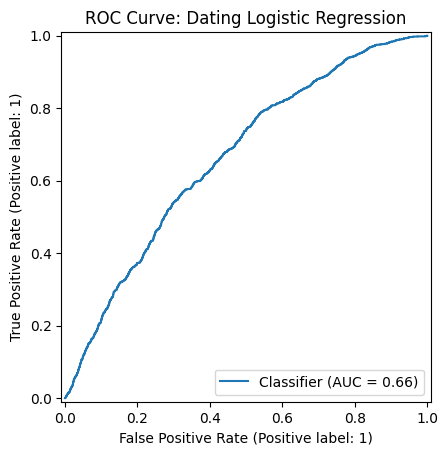

In [27]:
#----- get prob
probs = result.predict(X)  # fitted probabilities

#----- compute AUC
auc = roc_auc_score(y, probs)
print(f"AUC: {auc:.3f}")

#-----draw the graph
RocCurveDisplay.from_predictions(y, probs)

#-----add title
plt.title("ROC Curve: Dating Logistic Regression")
plt.show()

### Determining Optimal Model Threshold

In [30]:
#Define the thresholds 
thresholds = np.arange(0.0, 1.1, 0.1)

metrics_list = []

pred_prob = result.predict(X)
y_true = y.values.ravel()
auc_value = roc_auc_score(y_true, pred_prob)

for threshold in thresholds:
    # Convert probabilities to classes based on the current threshold
    pred_class = (pred_prob >= threshold).astype(int)
    
    # Handle the case where the predicted class is all 0s or all 1s (which can happen at extreme thresholds)
    # This prevents warnings or errors in precision/recall calculation
    try:
        accuracy = accuracy_score(y_true, pred_class)
        precision = precision_score(y_true, pred_class, zero_division=0)
        recall = recall_score(y_true, pred_class, zero_division=0)
    except ValueError:
        # If the prediction array is empty, set metrics to NaN
        accuracy = np.nan
        precision = np.nan
        recall = np.nan
    
    
    # Store results
    metrics_list.append({
        'Threshold': f"{threshold:.1f}",
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
    })

# Convert the list of dictionaries into a DataFrame
performance_df = pd.DataFrame(metrics_list)

# Sort the table by decreasing Accuracy

final_table = performance_df.sort_values(by='Accuracy', ascending=False).reset_index(drop=True)

print("\n--- Performance Metrics by Classification Threshold (Sorted by Accuracy) ---")
print(final_table)

# Original output for a single threshold (0.5)
pred_class_05 = (pred_prob >= 0.5).astype(int)
print("\nOriginal Metrics (threshold=0.5):")
acc_05  = (pred_class_05.values.ravel() == y_true).mean()
print(f"Accuracy: {acc_05:.3f} | ROC-AUC: {auc_value:.3f}")


--- Performance Metrics by Classification Threshold (Sorted by Accuracy) ---
   Threshold  Accuracy  Precision    Recall
0        0.6  0.902610   1.000000  0.000576
1        0.5  0.902554   0.500000  0.000576
2        0.7  0.902554   0.000000  0.000000
3        0.8  0.902554   0.000000  0.000000
4        0.9  0.902554   0.000000  0.000000
5        1.0  0.902554   0.000000  0.000000
6        0.4  0.902498   0.333333  0.000576
7        0.3  0.901431   0.083333  0.001152
8        0.2  0.885265   0.184426  0.051843
9        0.1  0.589952   0.144335  0.650922
10       0.0  0.097446   0.097446  1.000000

Original Metrics (threshold=0.5):
Accuracy: 0.903 | ROC-AUC: 0.664
